# Paper figures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client
import numpy as np
import catalog
import util
import pandas as pd
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from glob import glob
import matplotlib.gridspec as gridspec
from IPython.display import Image
import matplotlib.colors as colors

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT

### Parameters

In [4]:
casename = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001'
component = 'pop'
stream = 'h'

cluster_scheduler_address = None

In [5]:
assert component in ['pop']
assert stream in ['h', 'h.ecosys.nday1']

### Connect to cluster

In [6]:
if cluster_scheduler_address is None:
    cluster, client = util.get_ClusterClient()
    cluster.scale(12)
else:
    client = Client(cluster_scheduler_address)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:39348,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load the data

In [7]:
dsets = catalog.to_dataset_dict(
    case=casename,
    component=component,
    stream=stream,
)
dsets.keys()

g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001 pop h /glade/scratch/kristenk/archive


dict_keys(['g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001.pop.h'])

In [8]:
ds = dsets[f'{casename}.{component}.{stream}']

### Variable list

In [9]:
variables =['mesozooC', 'microzooC','diatChl', 'coccoChl',
            'spChl','diazChl','PO4','NO3','SiO3',
           'x_graze_mesozoo_zint','photoC_TOT_zint']

In [10]:
keep_vars=['z_t','z_t_150m','dz','time_bound','time','TAREA','TLAT','TLONG'] + variables
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### Make a monthly climatology dataset

In [11]:
time = pd.date_range(start="2009-01-01", end="2019-01-01",freq="M")

In [12]:
mon_ds = ds.copy()
mon_ds['time'] = time
mon_ds = ds.groupby('time.month').mean('time')

### Compute long-term mean

In [13]:
ds = ds.mean(dim='time')

#### Figure 1: MARBL 4p2z schematic with link to FEISTY

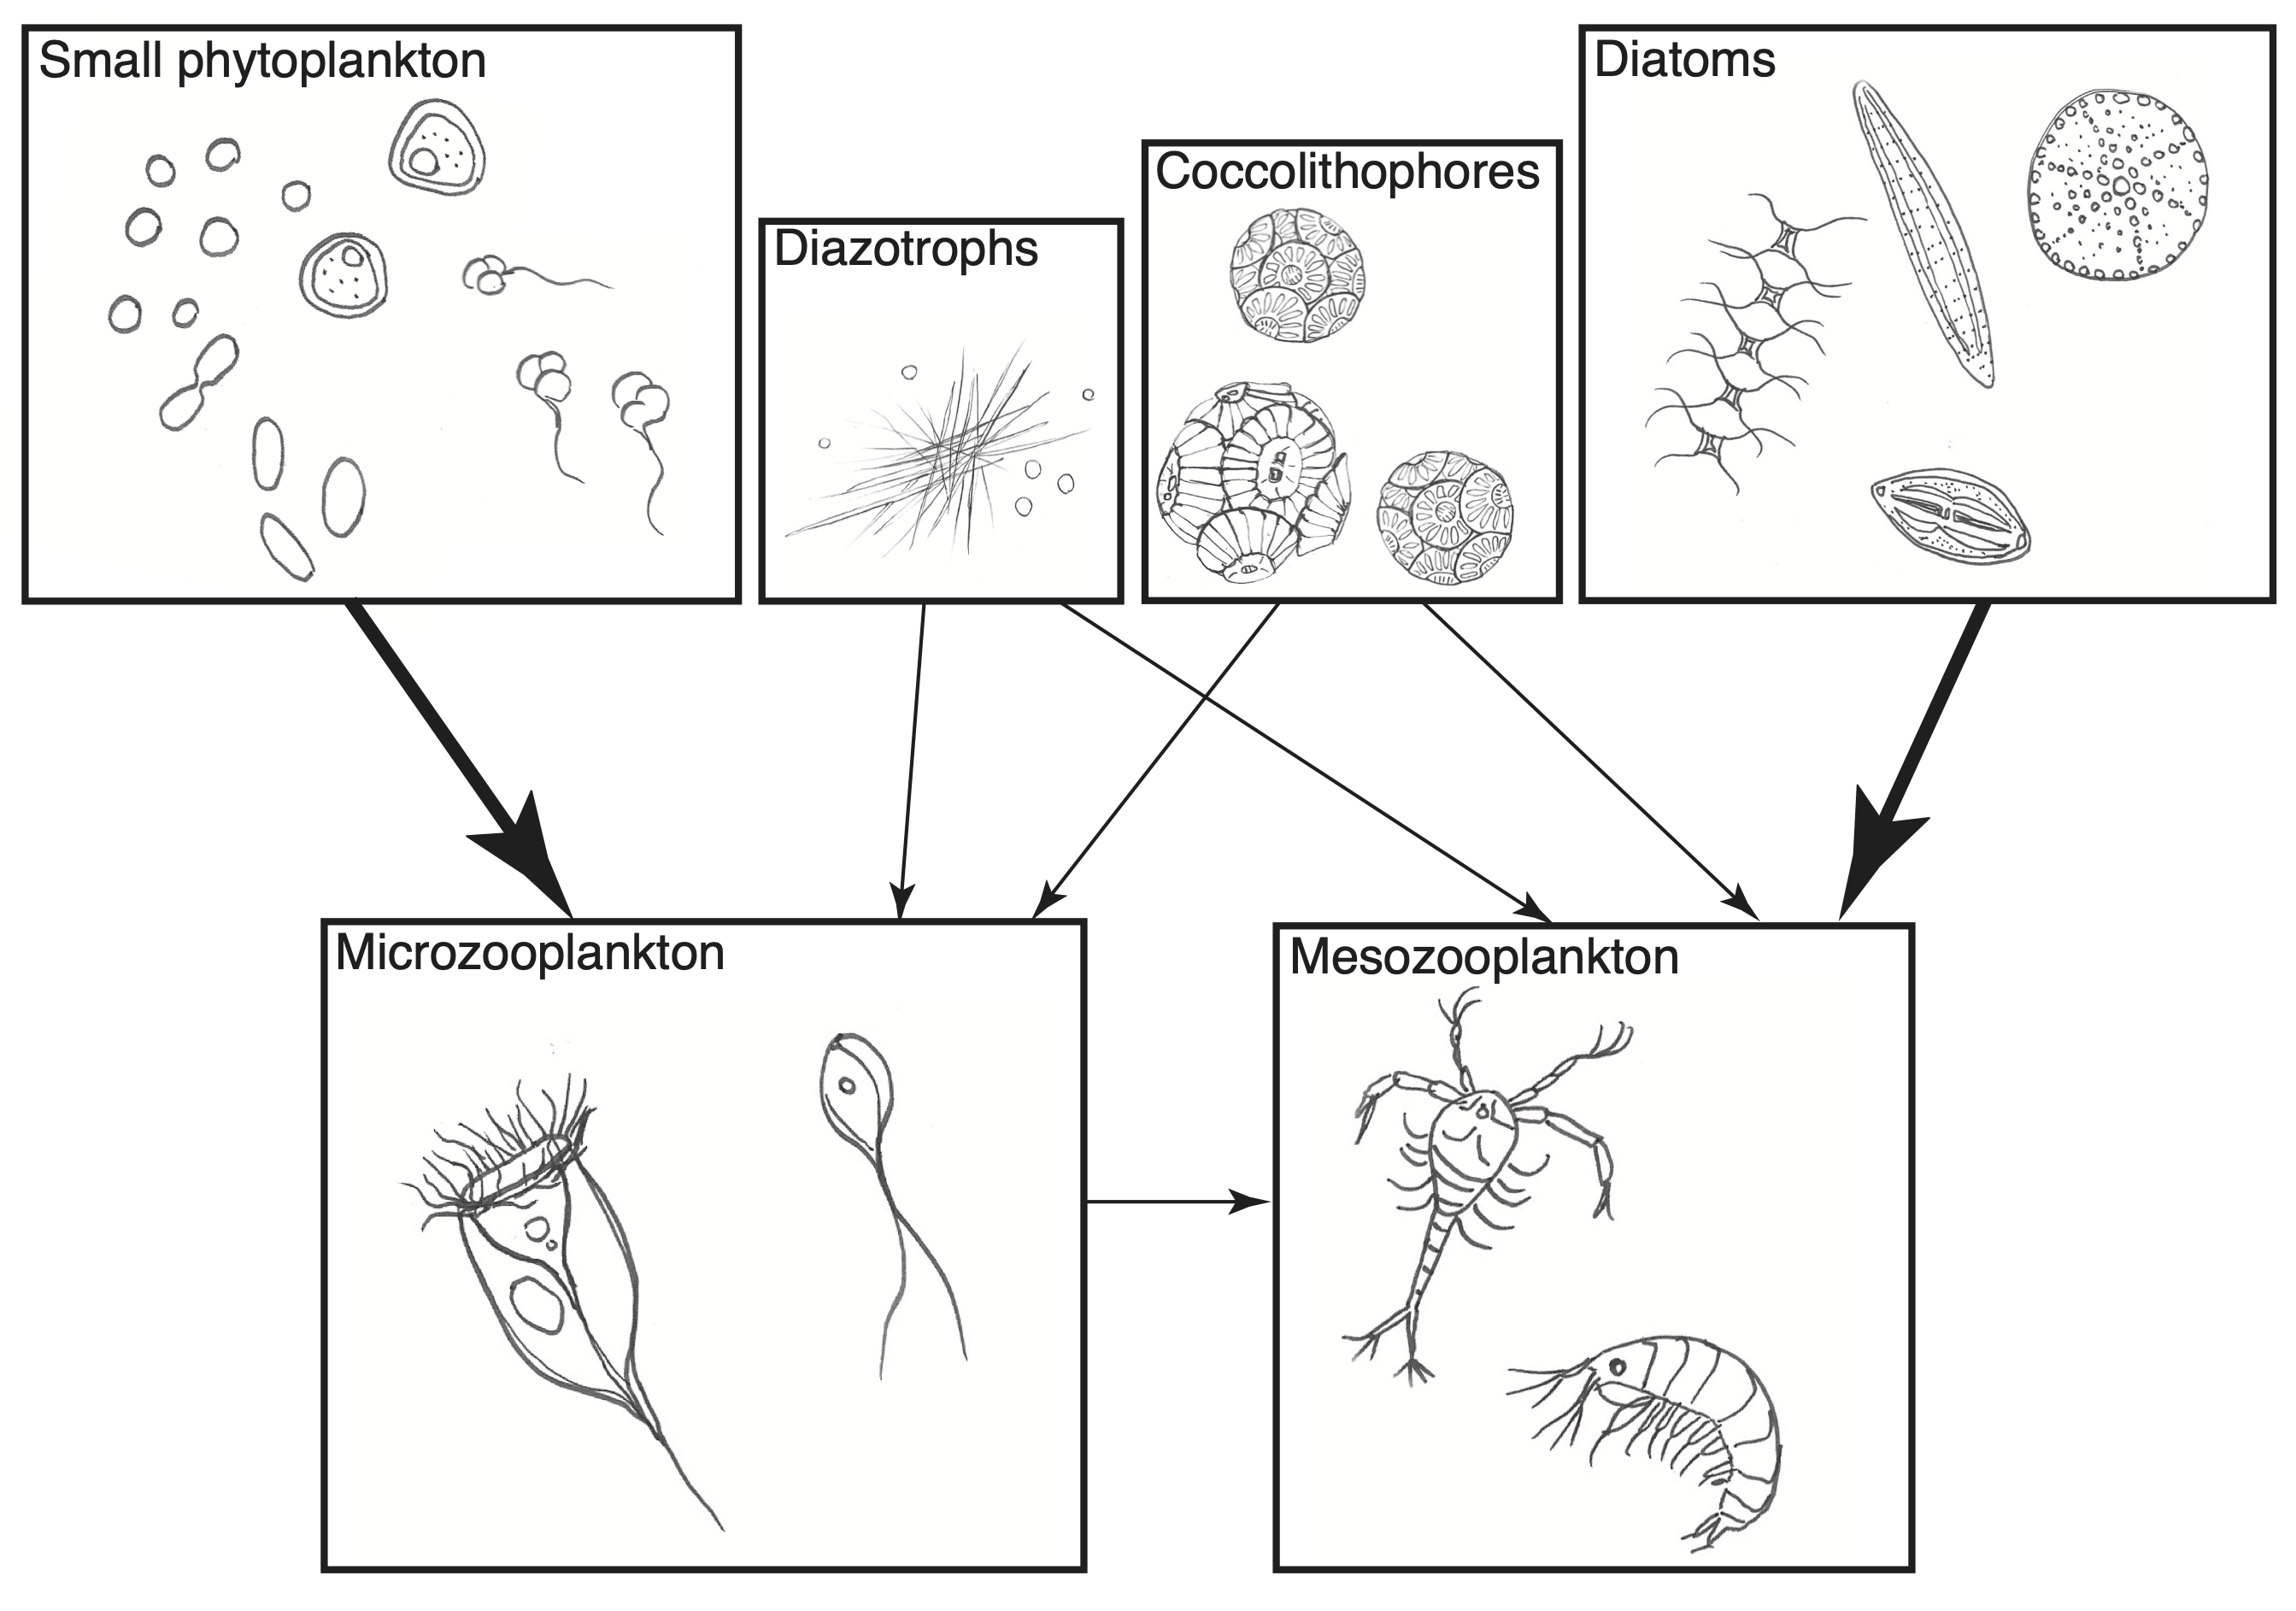

In [14]:
Image(filename='/glade/u/home/kristenk/new_4p2z_MARBL/scope4p2z_schematic2.png')

### Figure 2: macronutrient maps

In [15]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds.z_t

NO3_diff = ds.NO3 - ds_woa.NO3
PO4_diff = ds.PO4 - ds_woa.PO4
SiO3_diff = ds.SiO3 - ds_woa.SiO3

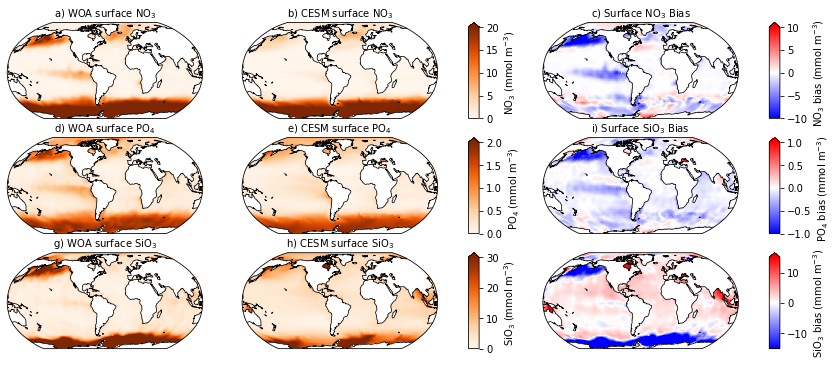

In [16]:
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(nrows=3, ncols=6, width_ratios=(1, 1, 0.05, 0.05, 1, 0.05))

prj = ccrs.Robinson(central_longitude=305.0)

ax_no3_woa = plt.subplot(gs[0, 0], projection=prj)
ax_no3_cesm = plt.subplot(gs[0, 1], projection=prj)
cax_no3 = plt.subplot(gs[0, 2])
ax_no3_diff = plt.subplot(gs[0, 4], projection=prj)
cax_no3_diff = plt.subplot(gs[0, 5])

ax_po4_woa = plt.subplot(gs[1, 0], projection=prj)
ax_po4_cesm = plt.subplot(gs[1, 1], projection=prj)
cax_po4 = plt.subplot(gs[1, 2])
ax_po4_diff = plt.subplot(gs[1, 4], projection=prj)
cax_po4_diff = plt.subplot(gs[1, 5])

ax_si_woa = plt.subplot(gs[2, 0], projection=prj)
ax_si_cesm = plt.subplot(gs[2, 1], projection=prj)
cax_si = plt.subplot(gs[2, 2])
ax_si_diff = plt.subplot(gs[2, 4], projection=prj)
cax_si_diff = plt.subplot(gs[2, 5])


### NO3 row
ax_no3_woa.set_title('a) WOA surface NO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=0))
pc1=ax_no3_woa.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_no3_woa.coastlines('110m',linewidth=0.75)

ax_no3_cesm.set_title('b) CESM surface NO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.NO3.isel(z_t=0))
pc1=ax_no3_cesm.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_no3_cesm.coastlines('110m',linewidth=0.75)

cb_no3 = plt.colorbar(pc1, cax=cax_no3,extend='max', 
                      label='NO$_3$ (mmol m$^{-3}$)')

ax_no3_diff.set_title('c) Surface NO$_3$ Bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, NO3_diff.isel(z_t=0))
pc1=ax_no3_diff.pcolormesh(lon, lat,field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_no3_diff.coastlines('110m',linewidth=0.75)

cb_no3_diff = plt.colorbar(pc1, cax=cax_no3_diff,extend='max', 
                      label='NO$_3$ bias (mmol m$^{-3}$)')


### PO4 row
ax_po4_woa.set_title('d) WOA surface PO$_4$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.PO4.isel(z_t=0))
pc1=ax_po4_woa.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_po4_woa.coastlines('110m',linewidth=0.75)

ax_po4_cesm.set_title('e) CESM surface PO$_4$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.PO4.isel(z_t=0))
pc1=ax_po4_cesm.pcolormesh(lon, lat, field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_po4_cesm.coastlines('110m',linewidth=0.75)

cb_po4 = plt.colorbar(pc1, cax=cax_po4,extend='max', 
                      label='PO$_4$ (mmol m$^{-3}$)')

ax_po4_diff.set_title('f) Surface PO$_4$ Bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, PO4_diff.isel(z_t=0))
pc1=ax_po4_diff.pcolormesh(lon, lat,field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_po4_diff.coastlines('110m',linewidth=0.75)

cb_po4_diff = plt.colorbar(pc1, cax=cax_po4_diff,extend='max', 
                      label='PO$_4$ bias (mmol m$^{-3}$)')


### SiO3 row
ax_si_woa.set_title('g) WOA surface SiO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.SiO3.isel(z_t=0))
pc1=ax_si_woa.pcolormesh(lon, lat,field, vmin=0, vmax=30, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_si_woa.coastlines('110m',linewidth=0.75)

ax_si_cesm.set_title('h) CESM surface SiO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.SiO3.isel(z_t=0))
pc1=ax_si_cesm.pcolormesh(lon, lat, field, vmin=0, vmax=30, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_si_cesm.coastlines('110m',linewidth=0.75)

cb_si = plt.colorbar(pc1, cax=cax_si,extend='max', 
                      label='SiO$_3$ (mmol m$^{-3}$)')

ax_po4_diff.set_title('i) Surface SiO$_3$ Bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, SiO3_diff.isel(z_t=0))
pc1=ax_si_diff.pcolormesh(lon, lat, field, vmin=-15, vmax=15, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_si_diff.coastlines('110m',linewidth=0.75)

cb_si_diff = plt.colorbar(pc1, cax=cax_si_diff,extend='max', 
                      label='SiO$_3$ bias (mmol m$^{-3}$)')

### Figure 3. Chlorophyll/COPEPOD comparison

[Garnesson et al., 2019](https://os.copernicus.org/articles/15/819/2019/)

[Moriarty & O'Brien, 2013](https://essd.copernicus.org/articles/5/45/2013/essd-5-45-2013.pdf)

In [17]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file, consolidated=False)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

In [18]:
ds['Chl_surf'] = ds.spChl.isel(z_t_150m=0) + ds.diatChl.isel(z_t_150m=0) + ds.coccoChl.isel(z_t_150m=0) + ds.diazChl.isel(z_t_150m=0)

In [19]:
path = '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_'
files = []
files.extend(sorted(glob(f'{path}*.nc')))
ds_sat=xr.open_mfdataset(files,concat_dim='time',combine='nested')
ds_sat = ds_sat.mean(dim='time')

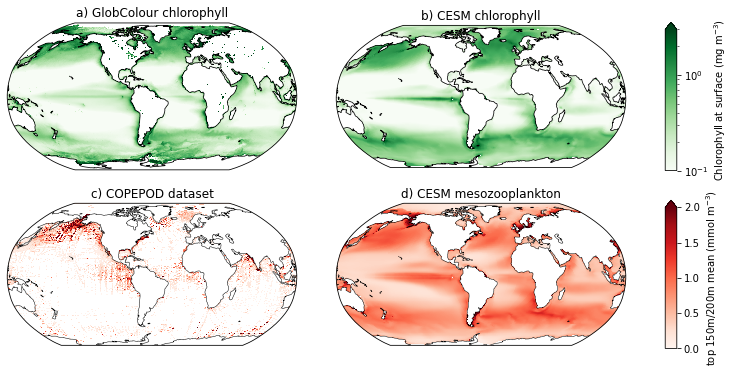

In [20]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_chl_sat = plt.subplot(gs[0, 0], projection=prj)
ax_chl_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_meso_cope = plt.subplot(gs[1, 0], projection=prj)
ax_meso_cesm = plt.subplot(gs[1, 1], projection=prj)

ax_chl_sat.set_title('a) GlobColour chlorophyll', fontsize=12)
pc_chl_sat=ax_chl_sat.pcolormesh(ds_sat.lon, ds_sat.lat, ds_sat.CHL1_mean, 
                     cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                     transform=ccrs.PlateCarree())
ax_chl_sat.coastlines('110m',linewidth=0.75)

ax_chl_cesm.set_title('b) CESM chlorophyll', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.Chl_surf)
ax_chl_cesm.coastlines('110m',linewidth=0.75)
pc_chl_cesm=ax_chl_cesm.pcolormesh(lon, lat, field, cmap='Greens',
                 norm=colors.LogNorm(vmin=0.1, vmax=3),transform=ccrs.PlateCarree())


ax_meso_cope.set_title('c) COPEPOD dataset', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds_copepod.copepod_C)
pc_meso_cope=ax_meso_cope.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)

ax_meso_cesm.set_title('d) CESM mesozooplankton', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.mesozooC.mean(dim='z_t_150m'))
pc_meso_cesm=ax_meso_cesm.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cesm.coastlines('110m',linewidth=0.5)

cax_chl = plt.subplot(gs[0, 2])
cax_meso = plt.subplot(gs[1, 2])

cb_chl = plt.colorbar(pc_chl_cesm, cax=cax_chl,extend='max', 
                      label='Chlorophyll at surface (mg m$^{-3}$)')
cb_meso = plt.colorbar(pc_meso_cesm, cax=cax_meso,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')

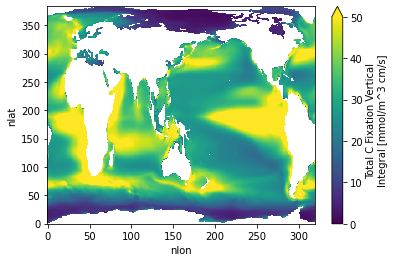

In [21]:
(ds.photoC_TOT_zint * 0.01 * 86400).plot(vmin=0,vmax=50)

#### Figure X. NPP, mesozoo prod, z-ratio.... or ETE, fish biomass maps

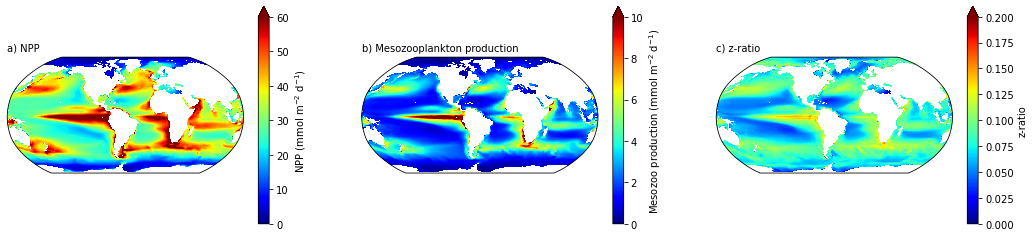

In [22]:
###### 
fig = plt.figure(figsize=(18,4))

ax = fig.add_subplot(1,3,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) NPP', fontsize=10,loc='left')
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint * 0.01 * 86400)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=60,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol m$^{-2}$ d$^{-1}$)')


ax = fig.add_subplot(1,3,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) Mesozooplankton production', fontsize=10,loc='left')
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.x_graze_mesozoo_zint * 0.01 * 86400)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mesozoo production (mmol m$^{-2}$ d$^{-1}$)')



ax = fig.add_subplot(1,3,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) z-ratio', fontsize=10,loc='left')
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.x_graze_mesozoo_zint/ds.photoC_TOT_zint)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='z-ratio')

#### Figure 5... seasonal cycles, interannual variability

#### Figure X. Regional maps that show mesoscale features..